In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

# List kaggle folders

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./JUGE_Vincent_documentation_et_code_112022.ipynb
./JUGE_Vincent_presentation_112022.pdf
./JUGE_Vincent_lien_kernel_kaggle_112022.txt
./index.md
./submission.csv
./module-p8.ipynb
./JUGE_Vincent_P8_112022.zip
./P8_Soutenance.pdf
./data/stores.csv
./data/oil.csv
./data/transactions.csv
./data/holidays_events.csv
./data/train.csv
./data/train_filled.csv
./data/test.csv
./data/sample_submission.csv


In [3]:
#!pip install "gluonts[mxnet,pro]"

## EDA

In [4]:
from datetime import datetime

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_test.date.min()
df_test.date.max()
min = datetime.strptime(df_test.date.min(), '%Y-%M-%d')
max = datetime.strptime(df_test.date.max(), '%Y-%M-%d')




'2017-08-16'

'2017-08-31'

In [5]:
df_train
df_train.shape
df_train.date.min()
df_train.date.max()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


(3000888, 6)

'2013-01-01'

'2017-08-15'

dataset starts from 2013-01-01 to 2017-08-15

predictions must be made from 2017-08-16 to 2017-08-31


In [6]:
df_train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

Do we have continuous dates ?

no : 25 december is missing for all


In [7]:
df_train.groupby(by=['date']).count()

df_train[df_train['date'] == '2013-12-24']
df_train[df_train['date'] == '2013-12-25']

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,1782,1782,1782,1782,1782
2013-01-02,1782,1782,1782,1782,1782
2013-01-03,1782,1782,1782,1782,1782
2013-01-04,1782,1782,1782,1782,1782
2013-01-05,1782,1782,1782,1782,1782
...,...,...,...,...,...
2017-08-11,1782,1782,1782,1782,1782
2017-08-12,1782,1782,1782,1782,1782
2017-08-13,1782,1782,1782,1782,1782


,id,date,store_nbr,family,sales,onpromotion
636174,636174,2013-12-24,1,AUTOMOTIVE,1.000,0
636175,636175,2013-12-24,1,BABY CARE,0.000,0
636176,636176,2013-12-24,1,BEAUTY,2.000,0
636177,636177,2013-12-24,1,BEVERAGES,1248.000,0
636178,636178,2013-12-24,1,BOOKS,0.000,0
...,...,...,...,...,...,...
637951,637951,2013-12-24,9,POULTRY,848.844,0
637952,637952,2013-12-24,9,PREPARED FOODS,40.000,0
637953,637953,2013-12-24,9,PRODUCE,0.000,0
637954,637954,2013-12-24,9,SCHOOL AND OFFICE SUPPLIES,0.000,0


,id,date,store_nbr,family,sales,onpromotion


### Fill missing dates


On each December 25, for each store and each category, set 'sales' to 0



In [8]:
# add missing dates to train dataset : required for fitting the model

un_store = df_train['store_nbr'].unique()
un_family = df_train['family'].unique()

tmp_df = pd.DataFrame(
    columns=['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'],
    )

for i, s in enumerate(un_store):
    for j, f in enumerate(un_family):
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2013-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True,
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2014-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2015-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2016-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )

print(tmp_df)
df_train = df_train.append(tmp_df)
df_train.to_csv('data/train_filled.csv')


     id        date store_nbr                      family sales onpromotion
0     0  2013-12-25         1                  AUTOMOTIVE     0           0
1     0  2014-12-25         1                  AUTOMOTIVE     0           0
2     0  2015-12-25         1                  AUTOMOTIVE     0           0
3     0  2016-12-25         1                  AUTOMOTIVE     0           0
4     0  2013-12-25         1                   BABY CARE     0           0
...  ..         ...       ...                         ...   ...         ...
7123  0  2016-12-25         9  SCHOOL AND OFFICE SUPPLIES     0           0
7124  0  2013-12-25         9                     SEAFOOD     0           0
7125  0  2014-12-25         9                     SEAFOOD     0           0
7126  0  2015-12-25         9                     SEAFOOD     0           0
7127  0  2016-12-25         9                     SEAFOOD     0           0

[7128 rows x 6 columns]


### Categorical Values 


Eventually encode categorical feature, maybe usefull for the model

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train['family_cat'] = le.fit_transform(df_train['family'])
le.classes_

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR WINE BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [10]:
nb_stores = df_train['store_nbr'].unique()
nb_stores

array([1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 6,
       7, 8, 9], dtype=object)

In [11]:
df_test['family_cat'] = le.fit_transform(df_test['family'])
df_test

,id,date,store_nbr,family,onpromotion,family_cat
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0
1,3000889,2017-08-16,1,BABY CARE,0,1
2,3000890,2017-08-16,1,BEAUTY,2,2
3,3000891,2017-08-16,1,BEVERAGES,20,3
4,3000892,2017-08-16,1,BOOKS,0,4
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,28
28508,3029396,2017-08-31,9,PREPARED FOODS,0,29
28509,3029397,2017-08-31,9,PRODUCE,1,30
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,31


### Set Index to be the date

Required for the model below


In [12]:
df_train.set_index('date', inplace=True)
df_train.sort_index(inplace=True)

In [13]:
df_test.set_index('date', inplace=True)
df_test

,id,store_nbr,family,onpromotion,family_cat
date,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,0
2017-08-16,3000889,1,BABY CARE,0,1
2017-08-16,3000890,1,BEAUTY,2,2
2017-08-16,3000891,1,BEVERAGES,20,3
2017-08-16,3000892,1,BOOKS,0,4
...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,1,28
2017-08-31,3029396,9,PREPARED FOODS,0,29
2017-08-31,3029397,9,PRODUCE,1,30


In [14]:
df_test['sales'] = 0

In [15]:
df_train.loc['2013-12-25']

,id,store_nbr,family,sales,onpromotion,family_cat
date,,,,,,
2013-12-25,0,41,PREPARED FOODS,0,0,29
2013-12-25,0,42,BOOKS,0,0,4
2013-12-25,0,42,BEVERAGES,0,0,3
2013-12-25,0,42,BEAUTY,0,0,2
2013-12-25,0,42,BABY CARE,0,0,1
...,...,...,...,...,...,...
2013-12-25,0,25,PET SUPPLIES,0,0,26
2013-12-25,0,25,PERSONAL CARE,0,0,25
2013-12-25,0,26,BEVERAGES,0,0,3


In [16]:
df_train

,id,store_nbr,family,sales,onpromotion,family_cat
date,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,0
2013-01-01,1194,42,CELEBRATION,0.0,0,6
2013-01-01,1193,42,BREAD/BAKERY,0.0,0,5
2013-01-01,1192,42,BOOKS,0.0,0,4
2013-01-01,1191,42,BEVERAGES,0.0,0,3
...,...,...,...,...,...,...
2017-08-15,2999695,25,POULTRY,172.517,0,28
2017-08-15,2999694,25,PLAYERS AND ELECTRONICS,3.0,0,27
2017-08-15,2999693,25,PET SUPPLIES,3.0,0,26


In [17]:
df_test.groupby(by=['store_nbr', 'family']).count()

id  onpromotion  family_cat  sales
store_nbr family                                                        
1         AUTOMOTIVE                  16           16          16     16
          BABY CARE                   16           16          16     16
          BEAUTY                      16           16          16     16
          BEVERAGES                   16           16          16     16
          BOOKS                       16           16          16     16
...                                   ..          ...         ...    ...
54        POULTRY                     16           16          16     16
          PREPARED FOODS              16           16          16     16
          PRODUCE                     16           16          16     16
          SCHOOL AND OFFICE SUPPLIES  16           16          16     16
          SEAFOOD                     16           16          16     16

[1782 rows x 4 columns]

The prediction length is for 16 days

## GluonTS

In [18]:
from gluonts.dataset.common import ListDataset
from gluonts.model.lstnet import LSTNetEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.pandas import PandasDataset


from gluonts.mx import Trainer

freq = "D"

context_length = 2000 # train on this number of points
prediction_length = 16 # see prediction lenght infered above, corresponds to the number of days from 2017-08-15 to 2017-08-31

In [19]:
# number of points to predict is actually the length of the test dataset for each store and each poduct familly
df_test.groupby(by=['store_nbr', 'family']).count()

id  onpromotion  family_cat  sales
store_nbr family                                                        
1         AUTOMOTIVE                  16           16          16     16
          BABY CARE                   16           16          16     16
          BEAUTY                      16           16          16     16
          BEVERAGES                   16           16          16     16
          BOOKS                       16           16          16     16
...                                   ..          ...         ...    ...
54        POULTRY                     16           16          16     16
          PREPARED FOODS              16           16          16     16
          PRODUCE                     16           16          16     16
          SCHOOL AND OFFICE SUPPLIES  16           16          16     16
          SEAFOOD                     16           16          16     16

[1782 rows x 4 columns]

#### Dataset Preparation

#### One Store

Since our dataset is a multivariate time series : date + store_nbr + family, and since our model below doesn't accepts more than one extra category (for multivariate datasets),
we want to split the training and predictions for each store_nbr. Otherwise the dataset is considered inconsistent

GluonTs accepts a specific format of dataset, which can be created from panda dataframe, but must follow a strict content.

let's try to do for one store only, first :

In [20]:
#
df = df_train [['store_nbr', 'family', 'sales', 'id']]
df = df [df['store_nbr'] == 1]
df = df.astype({'store_nbr': 'string', 'family':'string', 'sales': 'int'})
df.dtypes
df

store_nbr    string
family       string
sales         int64
id           object
dtype: object

,store_nbr,family,sales,id
date,,,,
2013-01-01,1,AUTOMOTIVE,0,0
2013-01-01,1,MAGAZINES,0,23
2013-01-01,1,LIQUOR WINE BEER,0,22
2013-01-01,1,LINGERIE,0,21
2013-01-01,1,LAWN AND GARDEN,0,20
...,...,...,...,...
2017-08-15,1,SEAFOOD,22,2999138
2017-08-15,1,SCHOOL AND OFFICE SUPPLIES,0,2999137
2017-08-15,1,PRODUCE,2240,2999136


In [21]:
np.unique(df['family']).size

33

In [22]:
# generate GluonTs Dataset

ds = PandasDataset.from_long_dataframe(df, freq='d', target='sales', item_id=['family'])


#### All Stores

do the same dataset preparation for all the 'nb_stores' stores

In [23]:
all_stores_ds = []

for store in nb_stores:
    df_tmp = df_train [['store_nbr', 'family', 'sales', 'id']]
    df_tmp = df_tmp [df_tmp['store_nbr'] == store]
    df_tmp = df_tmp.astype({'store_nbr': 'string', 'family':'string', 'sales': 'int'})
    ds_tmp = PandasDataset.from_long_dataframe(df_tmp, freq='d', target='sales', item_id='family')
    all_stores_ds.append({'store_nbr': store, 'ds': ds_tmp})

# all_stores_ds

In [24]:
all_stores_ds[0]['store_nbr']
all_stores_ds[0]['ds']


1

PandasDataset(dataframes={'AUTOMOTIVE':            store_nbr      family  sales       id
date                                            
2013-01-01         1  AUTOMOTIVE      0        0
2013-01-02         1  AUTOMOTIVE      2     1782
2013-01-03         1  AUTOMOTIVE      3     3564
2013-01-04         1  AUTOMOTIVE      3     5346
2013-01-05         1  AUTOMOTIVE      5     7128
...              ...         ...    ...      ...
2017-08-11         1  AUTOMOTIVE      1  2991978
2017-08-12         1  AUTOMOTIVE      6  2993760
2017-08-13         1  AUTOMOTIVE      1  2995542
2017-08-14         1  AUTOMOTIVE      1  2997324
2017-08-15         1  AUTOMOTIVE      4  2999106

[1688 rows x 4 columns], 'BABY CARE':            store_nbr     family  sales       id
date                                           
2013-01-01         1  BABY CARE      0        1
2013-01-02         1  BABY CARE      0     1783
2013-01-03         1  BABY CARE      0     3565
2013-01-04         1  BABY CARE      0     5

#### Model Training

In [25]:
from gluonts.evaluation import make_evaluation_predictions

def show_predictor(predictor, _ds):
    """plots the prediction

    Args:
        predictor (_type_): gluonTs predictor 
        _ds (_type_): gluonTs dataset
    """
    prediction = next(predictor.predict(_ds))
    print(prediction.mean)
    prediction.plot()

def get_forecasts(_ds):
    """gets forecasts for the given dataset

    Args:
        _ds (_type_): gluonTs dataset, contains the train and test data + prediction range

    Returns:
        _type_: tss and forecasts, two gluonTs forecasts structures
    """

    estimator = DeepAREstimator(
        freq=_ds.freq, 
        prediction_length=prediction_length, 
        trainer=Trainer(
            epochs=5,
            learning_rate=1e-3,
            num_batches_per_epoch=10,
            patience=2
            )
    )
    predictor = estimator.train(_ds)
    # show_predictor(predictor, _ds)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=10,  # number of sample paths we want for evaluation
    )
    tss = list(ts_it)
    forecasts = list(forecast_it)
    return tss, forecasts



In [26]:
def get_all_datastores(_all_stores_ds):
    """get forecasts for datastores

    Args:
        _all_stores_ds (_type_): array containing datastores to forecast
    """
    all_stores_forecasts = []
    for ds in _all_stores_ds:
        store_nbr = ds['store_nbr']
        ds = ds['ds']
        tss, forecasts = get_forecasts(ds)
        all_stores_forecasts.append({'store_nbr':store_nbr, 'tss': tss, 'forecasts': forecasts})
    return all_stores_forecasts

all_stores_forecasts = get_all_datastores(all_stores_ds)

100%|██████████| 10/10 [00:00<00:00, 16.75it/s, epoch=5/5, avg_epoch_loss=4.96]


In [27]:
# check results

all_stores_forecasts[0]['store_nbr']
all_stores_forecasts[0]['forecasts'][0].item_id

all_stores_forecasts[27]['store_nbr']
all_stores_forecasts[27]['forecasts'][0].mean

1

'AUTOMOTIVE'

34

array([3.7086303 , 4.52202   , 3.1379306 , 3.073627  , 0.7587561 ,
       2.0361521 , 2.4757113 , 0.02891867, 3.2297387 , 1.9927166 ,
       2.578484  , 1.574322  , 0.85237026, 3.1439483 , 1.6317594 ,
       2.102818  ], dtype=float32)

In [28]:
def show_forecasts(tss, forecasts):
    """shows some metrics of forecasts

    Args:
        tss (_type_): tss forecast
        forecasts (_type_): forecast
    """
    # first entry of the time series list
    len(tss[0])
    ts_entry = tss[0]
    ts_entry.tail(20)

    forecast_entry = forecasts[0]
    print(f"Number of sample paths: {forecast_entry.num_samples}")  
    print(f"Dimension of samples: {forecast_entry.samples.shape}")
    print(f"Start date of the forecast window: {forecast_entry.start_date}")
    print(f"Frequency of the time series: {forecast_entry.freq}")

    print(f"Mean of the future window:\n {forecast_entry.mean}")
    print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
    

In [29]:
show_forecasts(all_stores_forecasts[0]['tss'], all_stores_forecasts[0]['forecasts'])


Number of sample paths: 10
Dimension of samples: (10, 16)
Start date of the forecast window: 2017-07-31
Frequency of the time series: <Day>
Mean of the future window:
 [0.06522369 3.8557656  4.2982054  3.1106176  1.5668917  1.4009018
 1.8121979  3.4803352  2.5426145  4.0606127  3.2601993  3.8763046
 3.5215669  1.5939391  5.6682     3.7357106 ]
0.5-quantile (median) of the future window:
 [1.7211306 3.9172573 5.3777075 2.9965885 2.495524  3.737983  3.0013223
 3.1479006 3.826032  3.891008  2.803234  3.214735  2.323256  1.8485959
 2.8570812 3.8428042]


#### Predictions

In [30]:
def fill_df_with_predictions(df, all_forecasts):
    """fills a test dataframe with forecast results

    Args:
        df (_type_): dataframe to fill
        all_forecasts (_type_): array of datasets with their forecasts

    Returns:
        _type_: filled Dataframe
    """
    df_tmp = df.copy()
    
    for index, cast in enumerate(all_forecasts):
        store_nbr = all_forecasts[index]['store_nbr']
        store_fcasts = all_forecasts[index]['forecasts']
        categories_arr = [cast.item_id for cast in store_fcasts ]
        
        for index, cat in enumerate(categories_arr):
            cat_fcasts = store_fcasts[index]
            cat = cat_fcasts.item_id
            df_tmp.loc[(df_tmp['store_nbr']==store_nbr) & (df_tmp['family']==cat), 'sales'] = cat_fcasts.mean
    
    return df_tmp
        


In [31]:

df_tmp = fill_df_with_predictions(df_test, all_stores_forecasts)


In [32]:

df_tmp[(df_tmp['store_nbr'] == 1) & (df_tmp['family'] == 'BABY CARE')]

,id,store_nbr,family,onpromotion,family_cat,sales
date,,,,,,
2017-08-16,3000889,1,BABY CARE,0,1,11.527770
2017-08-17,3002671,1,BABY CARE,0,1,23.339928
2017-08-18,3004453,1,BABY CARE,0,1,17.542988
2017-08-19,3006235,1,BABY CARE,0,1,4.443448
2017-08-20,3008017,1,BABY CARE,0,1,16.204119
2017-08-21,3009799,1,BABY CARE,0,1,3.320149
2017-08-22,3011581,1,BABY CARE,0,1,-11.859850
2017-08-23,3013363,1,BABY CARE,0,1,19.933643
2017-08-24,3015145,1,BABY CARE,0,1,26.345255


In [33]:
df_tmp[['id', 'sales']].to_csv('submission.csv', index=False)

#### Evaluation of Performance

In [34]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(all_stores_forecasts[0]['tss'], all_stores_forecasts[0]['forecasts'])
agg_metrics['RMSE']
item_metrics

Running evaluation: 33it [00:00, 42.72it/s]
/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


202.34547820629948

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,AUTOMOTIVE,14.310936,40.594078,79.0,4.9375,2.769001,0.916262,0.630386,0.611970,0.513849,9.405197,19.360108,0.0625,40.594079,0.2500,24.341196,0.7500
1,BABY CARE,298.482605,233.855774,0.0,0.0000,0.000000,inf,NaN,2.000000,inf,inf,85.937252,0.3125,233.855772,0.7500,114.639380,1.0000
2,BEAUTY,7.687893,40.095299,62.0,3.8750,1.887493,1.327664,0.674215,0.855057,0.646698,13.739669,12.338877,0.0000,40.095297,0.1875,21.751560,0.8125
3,BEVERAGES,313778.687500,5469.461426,32066.0,2004.1250,489.121484,0.698888,0.277566,0.200394,0.170569,11.327198,5037.978223,0.2500,5469.461304,0.6875,2157.206445,0.9375
4,BOOKS,0.060347,1.418424,1.0,0.0625,0.149611,0.592547,0.971122,1.992983,1.418424,17.663980,0.466264,0.2500,1.418424,0.8125,2.002061,0.9375
5,BREAD/BAKERY,6368.958496,944.448120,4957.0,309.8125,109.183124,0.540633,0.282012,0.215644,0.190528,4.183737,703.986449,0.1250,944.448181,0.5625,518.233276,0.9375
6,CELEBRATION,71.645508,103.379425,160.0,10.0000,6.937163,0.931391,1.611188,0.684673,0.646121,7.893664,59.120855,0.4375,103.379430,0.7500,42.252688,0.8750
7,CLEANING,39555.554688,2420.727783,9503.0,593.9375,222.331538,0.680495,0.444357,0.292004,0.254733,5.788276,2056.027637,0.3125,2420.727722,0.6250,885.903027,0.8750
8,DAIRY,36285.082031,2016.982178,9815.0,613.4375,195.448235,0.644986,0.285353,0.224880,0.205500,8.512029,1478.427527,0.3125,2016.982117,0.7500,1027.339612,0.9375
9,DELI,1536.601929,463.572357,1922.0,120.1250,44.362657,0.653100,0.326273,0.265728,0.241193,6.639391,306.527032,0.2500,463.572365,0.5000,257.004364,0.9375


In [35]:
from gluonts.evaluation import Evaluator
from gluonts.evaluation import make_evaluation_predictions
import matplotlib.pyplot as plt
import json
import numpy as np

def plot_prob_forecasts(ts_entry, forecast_entry, _prediction_length, _context_length):
    """plots the signal and the forecast

    Args:
        ts_entry (_type_): gluon tss
        forecast_entry (_type_): gluon forecasts
        _prediction_length : number of points to predict
        _context_lenght = number of points used for prediction
    """
    plot_length = _context_length + _prediction_length
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [ f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(40, 20))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="cadetblue")
    plt.axvline(forecast_entry.start_date, color="g", lw=1) #end of train dataset
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.show()

def gluonts_metrics(tss, forecasts):
    """returns metrics for the preditor

    Args:
        tss (_type_): gluon tss
        forecasts (_type_): gluon forecasts
    """
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(tss, forecasts)

    print(json.dumps(agg_metrics, indent=4))


Show performance for one particular store_nbr

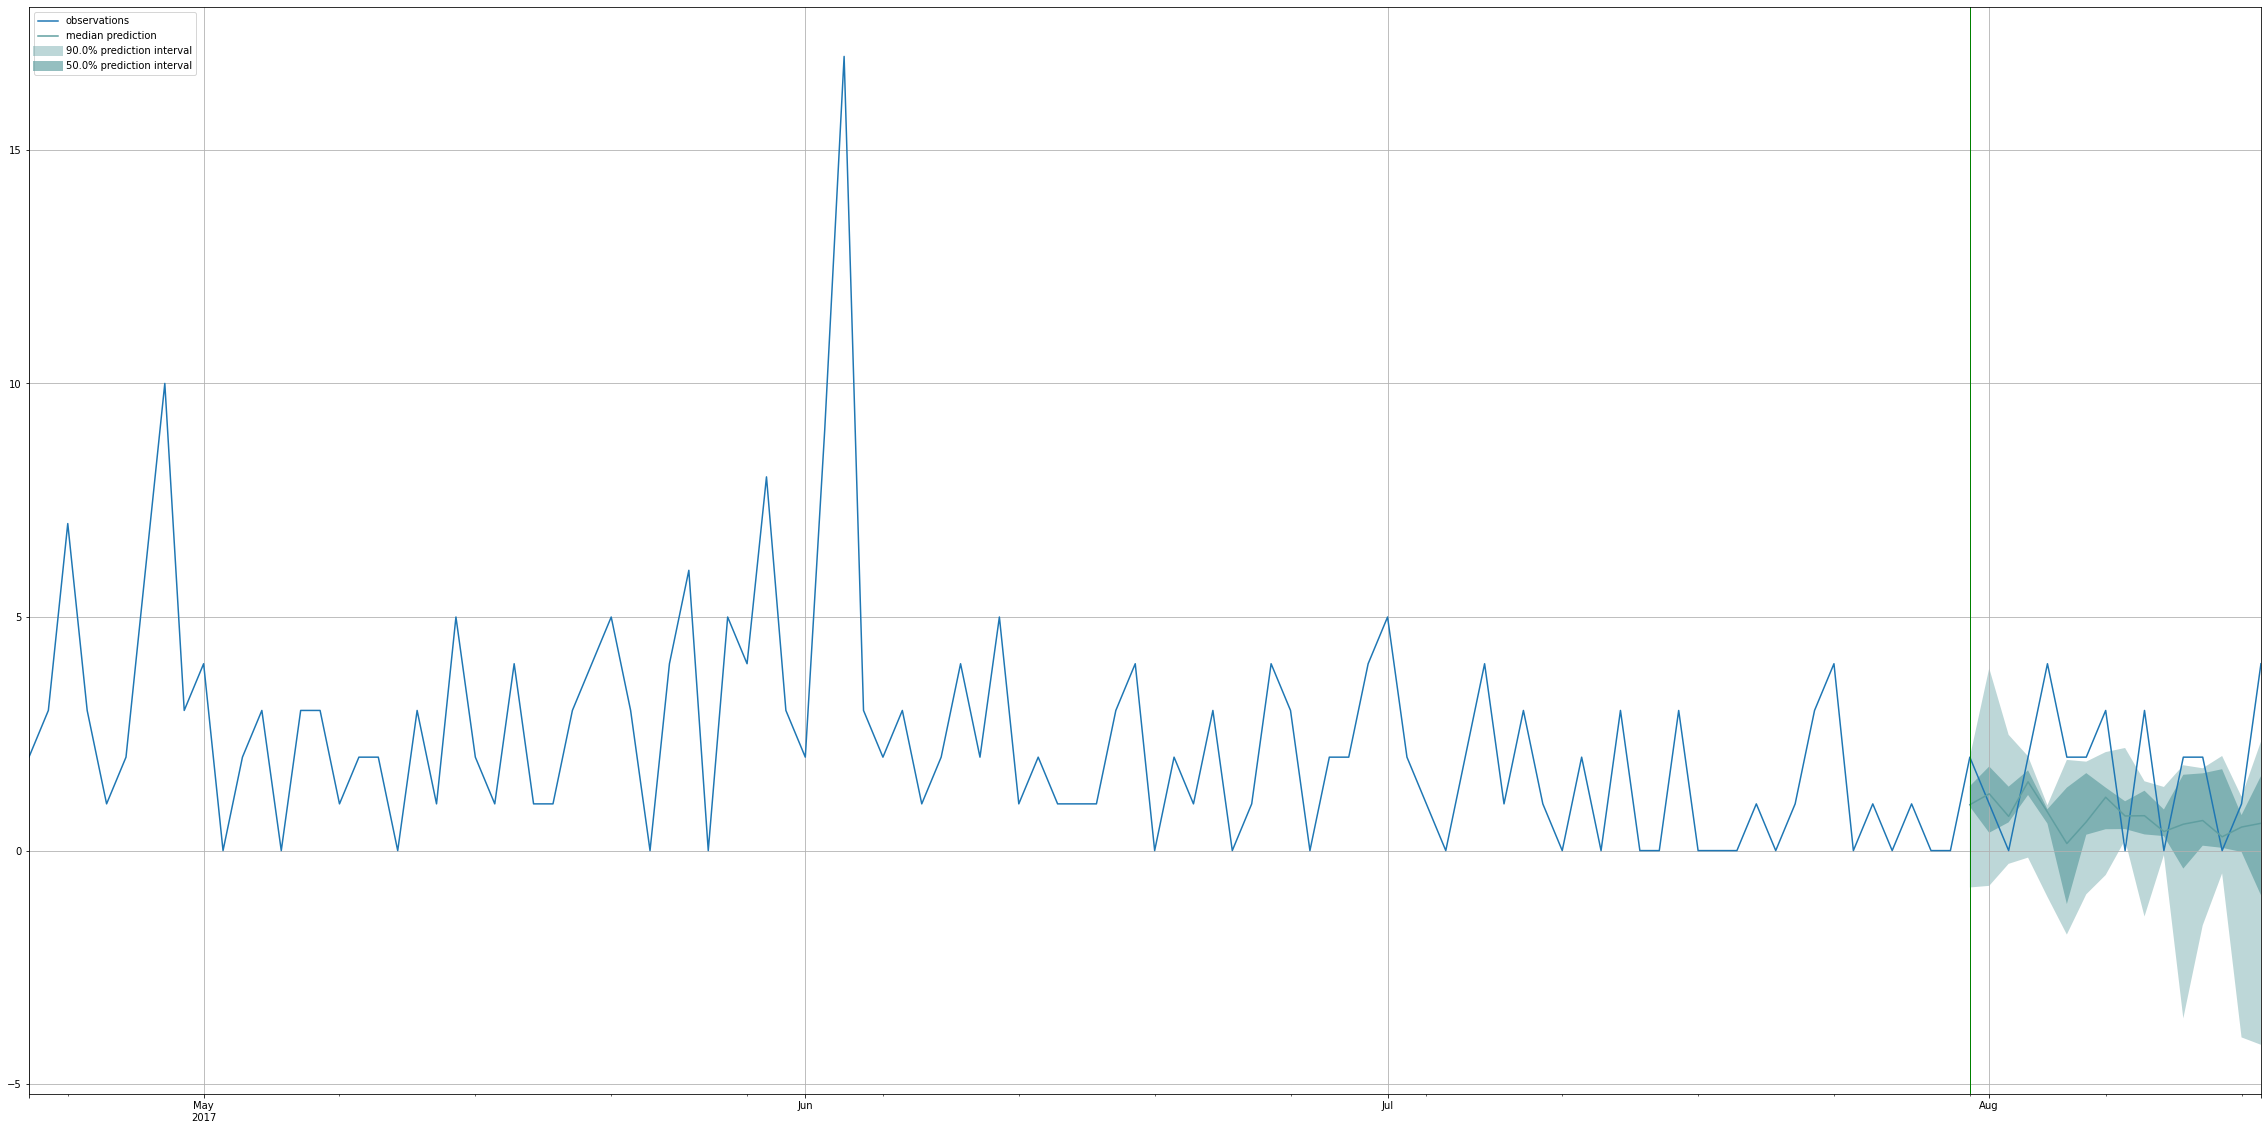

In [43]:
plot_prob_forecasts(
    all_stores_forecasts[1]['tss'][0],
    all_stores_forecasts[1]['forecasts'][0],
    prediction_length,
    (context_length-1900)
)

In [46]:
gluonts_metrics(all_stores_forecasts[1]['tss'], all_stores_forecasts[1]['forecasts'])

Running evaluation: 33it [00:00, 37.36it/s]

{
    "MSE": 21900.13315690083,
    "abs_error": 26563.325920939445,
    "abs_target_sum": 114829.0,
    "abs_target_mean": 217.47916666666666,
    "seasonal_error": 42.16946847287961,
    "MASE": Infinity,
    "MAPE": 0.5194750147079192,
    "sMAPE": 0.8317354113766642,
    "MSIS": Infinity,
    "QuantileLoss[0.1]": 10819.016206187382,
    "Coverage[0.1]": 0.09659090909090909,
    "QuantileLoss[0.5]": 26563.3261536255,
    "Coverage[0.5]": 0.3484848484848485,
    "QuantileLoss[0.9]": 15610.388170038535,
    "Coverage[0.9]": 0.7556818181818182,
    "RMSE": 147.98693576427897,
    "NRMSE": 0.6804648832920194,
    "ND": 0.23132941957989223,
    "wQuantileLoss[0.1]": 0.09421850060687964,
    "wQuantileLoss[0.5]": 0.23132942160626235,
    "wQuantileLoss[0.9]": 0.1359446496097548,
    "mean_absolute_QuantileLoss": 17664.243509950476,
    "mean_wQuantileLoss": 0.15383085727429893,
    "MAE_Coverage": 0.09974747474747474,
    "OWA": NaN
}


GluonTS multivariate :

<https://github.com/awslabs/gluonts/issues/494>

<https://github.com/awslabs/gluonts/issues/517>

<https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html>

